## 試してみたいこと
- chargeの予測の順番を変えてみる
- ↑をアンサンブルして予測してみる

In [1]:
# defact standard
import numpy as np
import pandas as pd
pd.set_option("max_rows", 500, "max_colwidth", 500, "max_columns", 500)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 前処理
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

# モデル
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

# チューニング
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 評価
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score

In [3]:
from google.colab import files

# uploaded = files.upload()

In [4]:
train_df = pd.read_csv("./train.csv")
print(train_df.shape)
train_df.head(15)

(1600, 8)


,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0
1,1,41,male,29.798725,1,no,southwest,0
2,2,28,male,32.722029,0,yes,northwest,1
3,3,20,female,38.429831,2,no,southeast,0
4,4,45,female,29.641854,1,no,northwest,0
5,5,20,male,37.785937,2,yes,southeast,1
6,6,37,male,43.393374,2,no,northeast,0
7,7,41,female,32.280407,1,no,northeast,0
8,8,40,male,28.865828,1,no,northeast,0
9,9,54,female,33.870887,2,no,northeast,0


In [5]:
pd.read_csv("./sample_submit.csv", header=None).head()

,0,1
0,13,0
1,23,0
2,27,0
3,28,0
4,29,0


# メモ
- そもそも保険の費用帯ってなに？
- 若い人より、お年寄りの方が高い？
- bmiが高い人ほど高い?
- 子供の数が多いほど高い?
- 喫煙者の方がもちろん高い？
- 地域によって関係あるか？

# 基礎集計

In [6]:
train_df.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
train_df.charges.value_counts()

0    1256
1     198
2     146
Name: charges, dtype: int64

### age

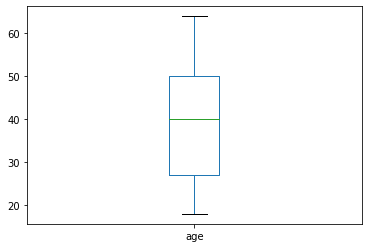

In [8]:
train_df.age.plot.box()

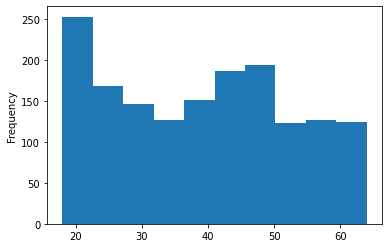

In [9]:
train_df.age.plot.hist(bins=10)

In [10]:
train_df["generation"] = train_df.age.apply(lambda x: "{}0歳代".format(x // 10))
train_df.head()

,id,age,sex,bmi,children,smoker,region,charges,generation
0,0,26,male,32.665465,3,no,southeast,0,20歳代
1,1,41,male,29.798725,1,no,southwest,0,40歳代
2,2,28,male,32.722029,0,yes,northwest,1,20歳代
3,3,20,female,38.429831,2,no,southeast,0,20歳代
4,4,45,female,29.641854,1,no,northwest,0,40歳代


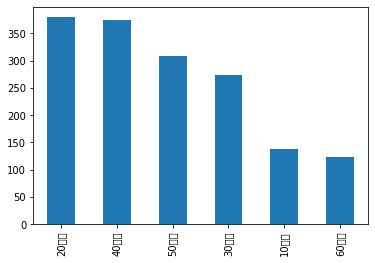

In [11]:
train_df.generation.value_counts().plot.bar()

### bmi

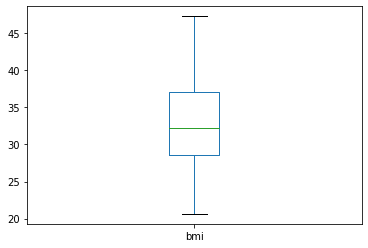

In [12]:
train_df.bmi.plot.box()

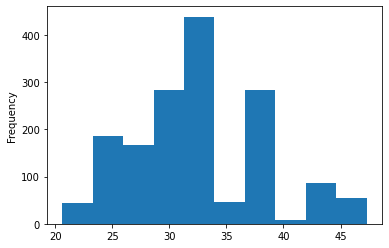

In [13]:
train_df.bmi.plot.hist(bins=10)

In [14]:
train_df["bmi_type"] = train_df.bmi.apply(lambda x: "{}BMI代".format(int((x // 4) * 4)))
train_df.head()

,id,age,sex,bmi,children,smoker,region,charges,generation,bmi_type
0,0,26,male,32.665465,3,no,southeast,0,20歳代,32BMI代
1,1,41,male,29.798725,1,no,southwest,0,40歳代,28BMI代
2,2,28,male,32.722029,0,yes,northwest,1,20歳代,32BMI代
3,3,20,female,38.429831,2,no,southeast,0,20歳代,36BMI代
4,4,45,female,29.641854,1,no,northwest,0,40歳代,28BMI代


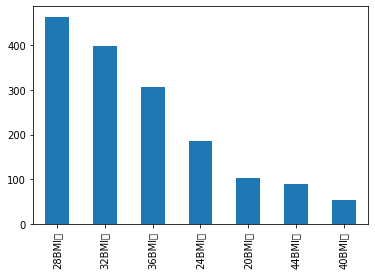

In [15]:
train_df.bmi_type.value_counts().plot.bar()

# 前処理

In [21]:
train_df.head()

,id,age,sex,bmi,children,smoker,region,charges,generation,bmi_type,pred
0,0,26,male,32.665465,3,no,southeast,0,20歳代,32BMI代,0
1,1,41,male,29.798725,1,no,southwest,0,40歳代,28BMI代,0
2,2,28,male,32.722029,0,yes,northwest,1,20歳代,32BMI代,1
3,3,20,female,38.429831,2,no,southeast,0,20歳代,36BMI代,0
4,4,45,female,29.641854,1,no,northwest,0,40歳代,28BMI代,0


In [22]:
oe = OrdinalEncoder()
oe_columns = ["sex", "smoker", "region", "generation", "bmi_type"]
train_df[oe_columns] = oe.fit_transform(train_df[oe_columns].values)
train_df.head()

,id,age,sex,bmi,children,smoker,region,charges,generation,bmi_type,pred
0,0,26,1.0,32.665465,3,0.0,2.0,0,1.0,3.0,0
1,1,41,1.0,29.798725,1,0.0,3.0,0,3.0,2.0,0
2,2,28,1.0,32.722029,0,1.0,1.0,1,1.0,3.0,1
3,3,20,0.0,38.429831,2,0.0,2.0,0,1.0,4.0,0
4,4,45,0.0,29.641854,1,0.0,1.0,0,3.0,2.0,0


In [23]:
train_df.drop(columns=["id", "age", "bmi", "pred"], inplace=True)
train_df.head()

,sex,children,smoker,region,charges,generation,bmi_type
0,1.0,3,0.0,2.0,0,1.0,3.0
1,1.0,1,0.0,3.0,0,3.0,2.0
2,1.0,0,1.0,1.0,1,1.0,3.0
3,0.0,2,0.0,2.0,0,1.0,4.0
4,0.0,1,0.0,1.0,0,3.0,2.0


In [24]:
train_df["charges_binary"] = train_df.charges.apply(lambda x: 0 if x == 0 else 1)
train_df.head()

,sex,children,smoker,region,charges,generation,bmi_type,charges_binary
0,1.0,3,0.0,2.0,0,1.0,3.0,0
1,1.0,1,0.0,3.0,0,3.0,2.0,0
2,1.0,0,1.0,1.0,1,1.0,3.0,1
3,0.0,2,0.0,2.0,0,1.0,4.0,0
4,0.0,1,0.0,1.0,0,3.0,2.0,0


In [25]:
feature_columns1 = ["children", "smoker", "generation", "bmi_type"]
X_train = train_df[feature_columns1].values
y_train = train_df["charges_binary"].values
print(X_train.shape, y_train.shape)

(1600, 4) (1600,)


In [27]:
LGBMC = LGBMClassifier()
param_grid = {
    "n_estimator": [30, 50,100],
    "max_depth": [3,5,7,9],
    "num_leaves": [3,5,7,9],
    "min_child_samples": [10, 20, 30],
    "min_child_weight": [0.001, 0.003, 0.01, 0.03],
    "learning_rate": [0.03, 0.1]
}
gs_rfc = GridSearchCV(estimator=LGBMC, param_grid=param_grid, scoring="f1_macro", cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=1)
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_samples': [10, 

In [29]:
print(gs_rfc.best_score_, gs_rfc.best_estimator_)
for x, y in zip(gs_rfc.best_estimator_.feature_importances_, feature_columns1):
    print(y, x)

0.8624164358697783 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimator=30, n_estimators=100, n_jobs=-1, num_leaves=3,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
children 50
smoker 52
generation 51
bmi_type 47


In [30]:
feature_columns2 = ["sex", "children", "region", "smoker", "generation", "bmi_type"]
X_train = train_df.query("charges != 0")[feature_columns2].values
y_train = train_df.query("charges != 0")["charges"].values
print(X_train.shape, y_train.shape)

(344, 6) (344,)


In [31]:
# GradientBoosting
# RandomForest
GBC = LGBMClassifier()
param_grid = {
    "n_estimator": [30, 50,100],
    "max_depth": [3,5,7,9],
    "num_leaves": [3,5,7,9],
    "min_child_samples": [10, 20, 30],
    "min_child_weight": [0.001, 0.003, 0.01, 0.03],
    "learning_rate": [0.03, 0.1]
}
gs_gbc = GridSearchCV(estimator=GBC, param_grid=param_grid, scoring="f1_macro", cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=2)
gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3 
[CV]  learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3, total=   0.0s
[CV] learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3 
[CV]  learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3, total=   0.0s
[CV] learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3 
[CV]  learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3, total=   0.0s
[CV] learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estimator=30, num_leaves=3 
[CV]  learning_rate=0.03, max_depth=3, min_child_samples=10, min_child_weight=0.001, n_estim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


ストリーミング出力は最後の 5000 行に切り捨てられました。
[CV] learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3 
[CV]  learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3 
[CV]  learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3 
[CV]  learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3 
[CV]  learning_rate=0.1, max_depth=3, min_child_samples=20, min_child_weight=0.01, n_estimator=50, num_leaves=3, total=   0.0s
[CV] learnin

[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_samples': [10, 

In [33]:
print(gs_gbc.best_score_, gs_gbc.best_estimator_)
for x, y in zip(gs_gbc.best_estimator_.feature_importances_, feature_columns2):
    print(y, x)

0.8185827718021157 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimator=30, n_estimators=100, n_jobs=-1, num_leaves=5,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
sex 44
children 53
region 52
smoker 57
generation 78
bmi_type 107


In [34]:
train_df["pred"] = gs_rfc.best_estimator_.predict(train_df[feature_columns1].values)

In [35]:
train_df.loc[train_df.pred == 1, "pred"] = gs_gbc.best_estimator_.predict(train_df.loc[train_df.pred == 1, feature_columns2].values)

In [36]:
f1_score(train_df.charges, train_df.pred, average="macro")

0.768619848080118

In [37]:
## テスト予測

In [38]:
test_df = pd.read_csv("./test.csv")
print(test_df.shape)
test_df.head()

(400, 7)


,id,age,sex,bmi,children,smoker,region
0,13,19,male,24.365178,1,no,northeast
1,23,59,male,33.997763,0,yes,northeast
2,27,42,female,29.283450,0,no,southwest
3,28,30,male,24.903725,1,no,northwest
4,29,41,female,29.644536,0,no,southwest


In [39]:
test_df["generation"] = test_df.age.apply(lambda x: "{}0歳代".format(x // 10))
test_df["bmi_type"] = test_df.bmi.apply(lambda x: "{}BMI代".format(int((x // 4) * 4)))
test_df[oe_columns] = oe.transform(test_df[oe_columns].values)

test_df["pred"] = gs_rfc.best_estimator_.predict(test_df[feature_columns1].values)
test_df.loc[test_df.pred == 1, "pred"] = gs_gbc.best_estimator_.predict(test_df.loc[test_df.pred == 1, feature_columns2].values)

NameError: ignored

In [41]:
test_df.pred.value_counts()

0    330
1     36
2     34
Name: pred, dtype: int64

In [42]:
test_df[["id", "pred"]].to_csv("./submit.csv", header=None, columns=None, index=None)

In [43]:
pd.read_csv("./submit.csv", header=None).head()

,0,1
0,13,0
1,23,2
2,27,0
3,28,0
4,29,0


In [44]:
files.download('./submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>